### Imports

In [53]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
import pandas as pd
from tensorflow import keras
from keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

### Untarring and Saving to Local Directory

In [54]:
fullPath = os.path.abspath("./" + "lfw.tgz")
data_lfw = keras.utils.get_file("lfw.tgz", 'file://'+ fullPath, untar=True, cache_dir=".")
dataset_dir = os.path.join(os.path.dirname(data_lfw), "lfw")

### Creating Dataset from Images

In [55]:
data_dir_1 = "./datasets/test_dataset"
# data_dir_2 = "./datasets/nonface"
image_size = 256
batch_size = 32
color_bytes = 3

# train_data, test_data = tf.keras.preprocessing.image_dataset_from_directory(data_dir, validation_split=0.2, subset="both", seed=20, image_size=image_size, batch_size=batch_size)


In [56]:
# Getting number of files in directory

count = 0
for root_dir, cur_dir, files in os.walk(data_dir_1):
    count += len(files)
print('file count:', count)


file count: 1311


In [57]:
# Creating Dataset from Face Images

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_1,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(image_size,image_size),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_1,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(image_size,image_size),
  batch_size=batch_size)

# Creating Dataset from Non Face Images

# train_ds_1 = tf.keras.utils.image_dataset_from_directory(
#   data_dir_2,
#   validation_split=0.2,
#   subset="training",
#   seed=123,
#   image_size=(image_size,image_size),
#   batch_size=batch_size)

# val_ds_1 = tf.keras.utils.image_dataset_from_directory(
#   data_dir_2,
#   validation_split=0.2,
#   subset="validation",
#   seed=123,
#   image_size=(image_size,image_size),
#   batch_size=batch_size)

# Combining Non Face and Face Images into One Dataset

# train_ds = train_ds.concatenate(train_ds_1)
# val_ds = val_ds.concatenate(val_ds_1)

Found 1309 files belonging to 2 classes.
Using 1048 files for training.
Found 1309 files belonging to 2 classes.
Using 261 files for validation.


### Displaying Sample Data

In [58]:
class_names = train_ds.class_names
print(class_names)

['grape_leaves', 'pokemon']


2022-11-28 00:42:08.726656: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


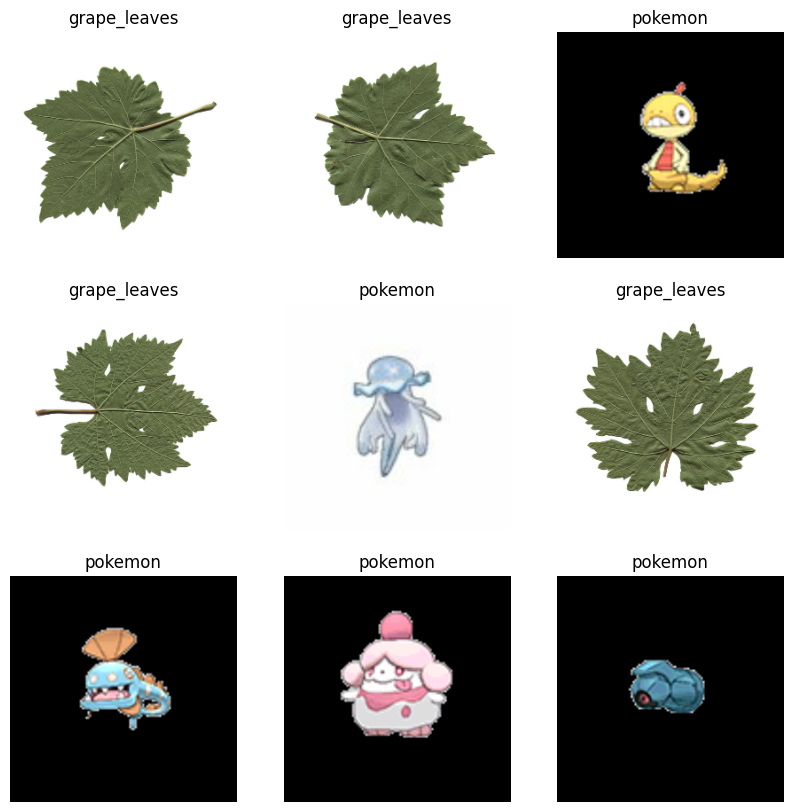

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [60]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

In [61]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [62]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 64)       

In [63]:
#result = self.step(batch, self.forward_only)

epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/5
33/33 [==============================] - 26s 747ms/step - loss: 0.1906 - accuracy: 0.9256 - val_loss: 0.0217 - val_accuracy: 0.9923
Epoch 2/5
33/33 [==============================] - 21s 631ms/step - loss: 0.0175 - accuracy: 0.9924 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 3/5
33/33 [==============================] - 20s 609ms/step - loss: 0.0170 - accuracy: 0.9971 - val_loss: 3.1258e-04 - val_accuracy: 1.0000
Epoch 4/5
33/33 [==============================] - 27s 817ms/step - loss: 0.0055 - accuracy: 0.9971 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 5/5
33/33 [==============================] - 21s 649ms/step - loss: 0.0129 - accuracy: 0.9971 - val_loss: 6.3976e-04 - val_accuracy: 1.0000


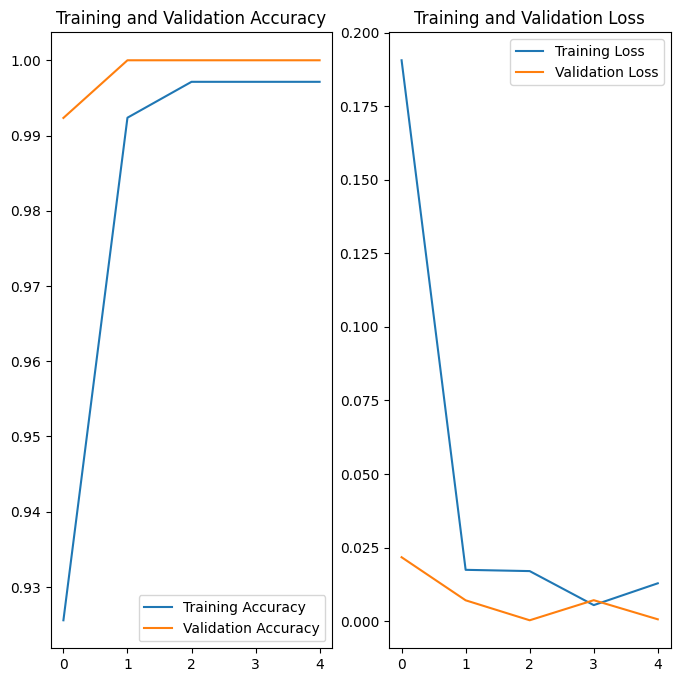

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [65]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(256,256,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

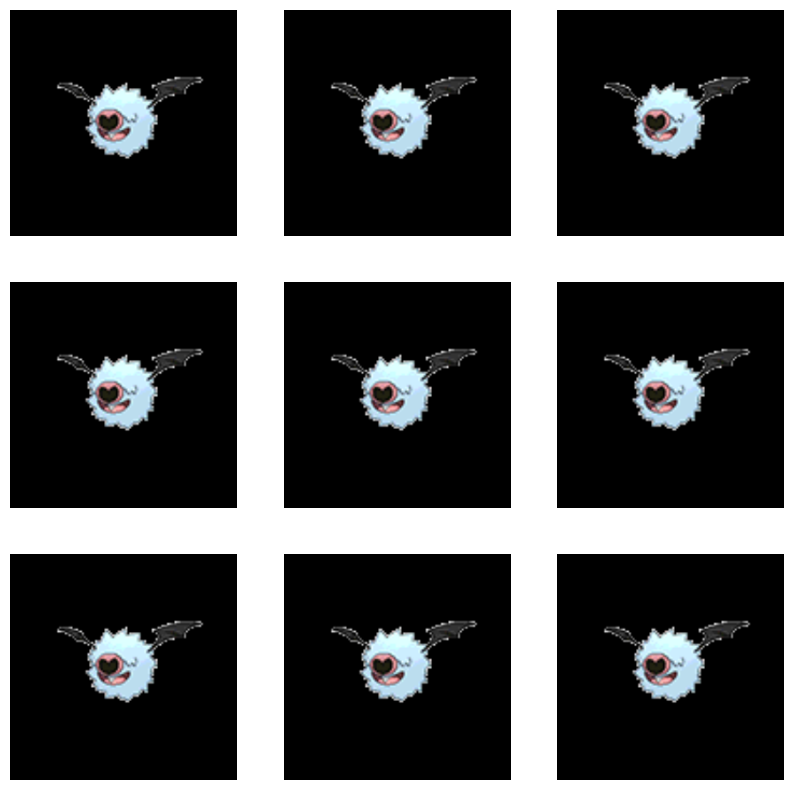

In [66]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [67]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [68]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 128, 128, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                 

In [74]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
33/33 [==============================] - 26s 800ms/step - loss: 0.0101 - accuracy: 0.9962 - val_loss: 8.7450e-04 - val_accuracy: 1.0000
Epoch 2/20
33/33 [==============================] - 26s 806ms/step - loss: 0.0103 - accuracy: 0.9990 - val_loss: 2.2082e-04 - val_accuracy: 1.0000
Epoch 3/20
33/33 [==============================] - 26s 808ms/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 6.2372e-05 - val_accuracy: 1.0000
Epoch 4/20
33/33 [==============================] - 25s 754ms/step - loss: 0.0017 - accuracy: 0.9990 - val_loss: 8.0979e-06 - val_accuracy: 1.0000
Epoch 5/20
33/33 [==============================] - 30s 919ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 1.6148e-06 - val_accuracy: 1.0000
Epoch 6/20
33/33 [==============================] - 24s 723ms/step - loss: 1.1408e-04 - accuracy: 1.0000 - val_loss: 5.1189e-04 - val_accuracy: 1.0000
Epoch 7/20
33/33 [==============================] - 24s 738ms/step - loss: 9.3193e-05 - accuracy: 1.0000 - val_los

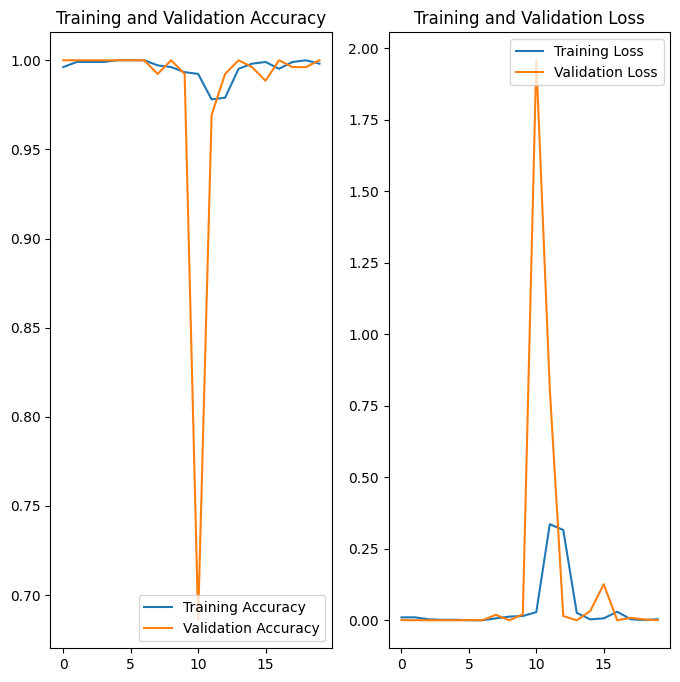

In [75]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [81]:
img_url = "https://previews.123rf.com/images/alfastudio/alfastudio1707/alfastudio170700394/81977398-close-up-green-organic-and-fresh-grape-leaf-on-a-black-background-dark-green-leaf-on-the-shadowy-bac.jpg"
img_path = tf.keras.utils.get_file('test_img_2', origin=img_url)

img = tf.keras.utils.load_img(
    img_path, target_size=(image_size, image_size)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
print(predictions)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 29ms/step
[[ 0.94611084 -1.0575458 ]]
This image most likely belongs to grape_leaves with a 88.12 percent confidence.
